# Learning Order Relations

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-colorblind')

import itertools

2023-04-09 18:40:14.790442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 18:40:14.962528: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 18:40:15.004758: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-09 18:40:15.821129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Order Relation Model


**Task**: Given two objects $(o_1, o_2) \in \mathcal{O} \times \mathcal{O}$, predict the relation $o_1 \prec o_2$

**Model**: 
1) Embed each object: $o_1 \mapsto e_1, o_2 \mapsto e_2$
2) Project the first object via $W^1$ and the second object via $W^2$, then compute inner product: $\langle W^1 e_1, W^2 e_2 \rangle$.
3) Return relation as sigmoid function $\text{Sigmoid}\left( \langle W^1 e_1, W^2 e_2 \rangle \right)$

*Note:* Here, the objects are tokens. (i.e.: integers. so the embedding layer maps $i \mapsto e_i$ for each $i \in \{1, ..., |\mathcal{O}| \}$)

In [2]:
class OrderRelation(tf.keras.Model):
    def __init__(self, num_objects, embedding_dim, proj_dim, name=None):
        super().__init__(name=name)
        self.num_objects = num_objects
        self.embedding_dim = embedding_dim
        self.proj_dim = proj_dim
    
    def build(self, input_shape):

        self.embedding = layers.Embedding(input_dim=self.num_objects, output_dim=self.embedding_dim)

        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.1, seed=1)
        self.W1 = tf.Variable(normal_initializer(shape=(self.embedding_dim, self.proj_dim)), trainable=True)
        self.W2 = tf.Variable(normal_initializer(shape=(self.embedding_dim, self.proj_dim)), trainable=True)
    
    def compute_innerprod_rel(self, inputs):
        embeddings = self.embedding(inputs)
        
        o1 = embeddings[:, 0]
        o2 = embeddings[:, 1]
        e1 = tf.matmul(o1, self.W1)
        e2 = tf.matmul(o2, self.W2)

        innerprod_rel = tf.einsum('ij,ij->i', e1, e2) # compute inner product

        return innerprod_rel

    def call(self, inputs):

        innerprod_rel = self.compute_innerprod_rel(inputs)

        return tf.nn.sigmoid(innerprod_rel)

## Order Relation Dataset

Model is fit on all pairs of objects and their associated relations.

In [3]:
# create data set for learning order relatios
num_objects = 64
object_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (object_pairs[:,0] < object_pairs[:, 1]).astype(int)

In [4]:
sample = np.random.choice(len(object_pairs), 10)
for object_pair, relation in zip(object_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(object_pair)}; relation: {relation}')

object pair: (8, 55); relation: 1
object pair: (15, 5); relation: 0
object pair: (33, 0); relation: 0
object pair: (28, 7); relation: 0
object pair: (51, 36); relation: 0
object pair: (18, 33); relation: 1
object pair: (59, 38); relation: 0
object pair: (38, 36); relation: 0
object pair: (27, 51); relation: 1
object pair: (52, 40); relation: 0


## Fit Relation Model

In [5]:
embedding_dim = 16
proj_dim = 8

order_relation = OrderRelation(num_objects, embedding_dim, proj_dim, name='order_relation')
order_relation(object_pairs); # build model
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
order_relation.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')

2023-04-09 18:40:19.961544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 18:40:22.141340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [6]:
order_relation.fit(object_pairs, object_order_relations, epochs=100, batch_size=len(object_pairs))

Epoch 1/100
1/1 [==============================] - 1s 799ms/step - loss: 0.6931 - binary_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6931 - binary_accuracy: 0.5171
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6925 - binary_accuracy: 0.7790
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6863 - binary_accuracy: 0.9117
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6639 - binary_accuracy: 0.9531
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6075 - binary_accuracy: 0.9616
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 0.4992 - binary_accuracy: 0.9630
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3427 - binary_accuracy: 0.9665
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1905 - binary_accuracy: 0.9747
Epoch 10/100
1/1 [==============================] - 0s 5ms/ste

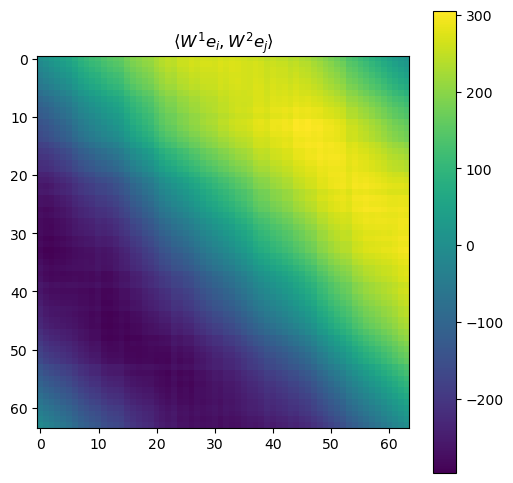

In [12]:
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        order_relation_matrix[i,j] = order_relation.compute_innerprod_rel(np.array([[i,j]]))[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix)
fig.colorbar(im, ax=ax);
ax.set_title('$\\langle W_1 e_i, W_2 e_j \\rangle$');

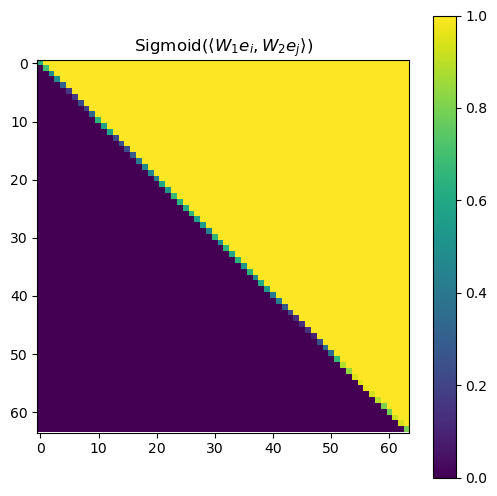

In [17]:
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        order_relation_matrix[i,j] = order_relation(np.array([[i,j]]))[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix)
fig.colorbar(im, ax=ax);
ax.set_title('$\\mathrm{Sigmoid}(\\langle W_1 e_i, W_2 e_j \\rangle)$');

# Learn Order Relation with `SimpleAbstractor`

In [18]:
import sys; sys.path.append('..'); sys.path.append('../..')

from abstracters import SimpleAbstractor

In [19]:
class AbstractorOrderRelation(tf.keras.Model):
    def __init__(self, name=None):
        super().__init__(name=name)
    
    def build(self, input_shape):
        self.abstractor = SimpleAbstractor(num_layers=1, num_heads=1, dff=32, use_pos_embedding=False)
        self.concat = layers.Concatenate()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.abstractor(inputs)
        x = self.concat([x[:, 0], x[:, 1]])
        x = self.dense(x)

        return x 

In [20]:
object_pairs_onehot = tf.one_hot(object_pairs, num_objects)

In [95]:
model = AbstractorOrderRelation()
model(object_pairs_onehot)
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.summary()

Model: "abstractor_order_relation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relational_abstracter (Simp  multiple                 21216     
 leAbstractor)                                                   
                                                                 
 concatenate_1 (Concatenate)  multiple                 0         
                                                                 
 dense_3 (Dense)             multiple                  129       
                                                                 
Total params: 21,345
Trainable params: 21,345
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.fit(object_pairs_onehot, object_order_relations, epochs=500, batch_size=len(object_pairs))

Epoch 1/500
1/1 [==============================] - 1s 826ms/step - loss: 0.7368 - binary_accuracy: 0.5012
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 6.0065 - binary_accuracy: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 1.0965 - binary_accuracy: 0.5002
Epoch 4/500
1/1 [==============================] - 0s 9ms/step - loss: 2.5088 - binary_accuracy: 0.5002
Epoch 5/500
1/1 [==============================] - 0s 8ms/step - loss: 2.0124 - binary_accuracy: 0.5000
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 0.8882 - binary_accuracy: 0.5000
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 0.9653 - binary_accuracy: 0.5002
Epoch 8/500
1/1 [==============================] - 0s 8ms/step - loss: 0.9617 - binary_accuracy: 0.5007
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7101 - binary_accuracy: 0.4861
Epoch 10/500
1/1 [==============================] - 0s 8ms/st

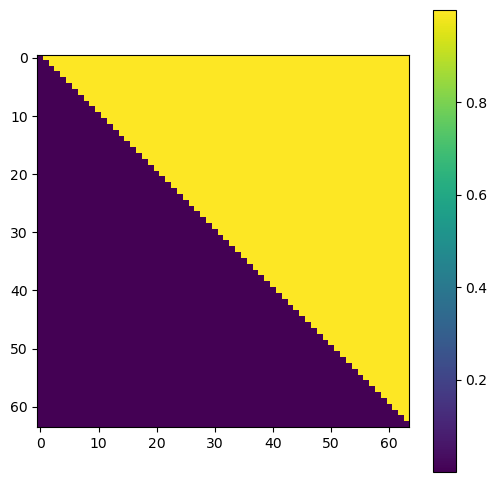

In [97]:
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        inputs = tf.one_hot(np.array([[i,j]]), num_objects)
        order_relation_matrix[i,j] = model(inputs)[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix)
fig.colorbar(im, ax=ax);

In [101]:
objects = tf.expand_dims(tf.one_hot(np.arange(num_objects), num_objects), axis=0)

In [109]:
relational_crossattention = model.abstractor.abstracter_layers[0].relational_crossattention.mha

In [110]:
attention_output, attention_scores = relational_crossattention(query=objects, key=objects, value=objects, return_attention_scores=True)
attention_scores = np.squeeze(attention_scores)

In [80]:
relations = tf.einsum('ijks,ijks -> js', relational_crossattention._query_dense(objects), relational_crossattention._key_dense(objects))

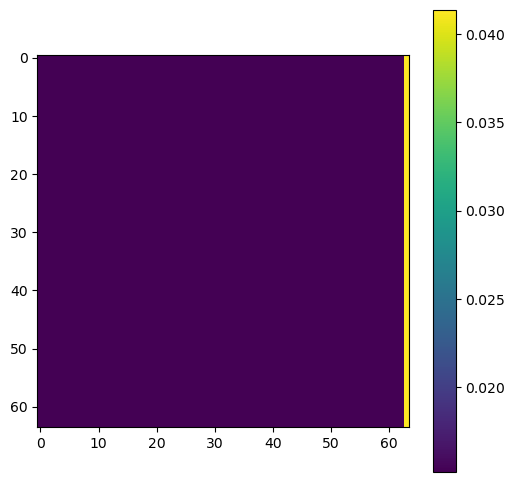

In [115]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(tf.nn.softmax(attention_scores, axis=-1))
fig.colorbar(im, ax=ax);